In [169]:
#!pip install syntheval

In [170]:
import pandas as pd
import numpy as np

In [171]:
# Go to the /users/pgrad/mamu/Documents/first/ directory 
import os
#os.chdir('/users/pgrad/mamu/Documents/first')
os.chdir('D:/maxim/Dissertation/first')

In [172]:
# Load datasets
original_data = pd.read_csv('./datasets/data.csv')
generated_data = pd.read_csv('./llama3-8b/results/synthetic_data_llama_3_8b.csv')

# Subset the datasets to the minimum length
min_len = min(len(original_data), len(generated_data))
original_data = original_data.iloc[:min_len]
generated_data = generated_data.iloc[:min_len]


In [173]:
# import the categories dictionary from json
import json

with open('./evaluation/tools/categories.json') as f:
    categories = json.load(f)

# Initialize the category counts
categories_count = {
    "Respiratory": 0,
    "Skin": 0,
    "Endocrine and Metabolic": 0,
    "Mental and Behavioral": 0,
    "Cardiovascular": 0,
    "Gastrointestinal": 0,
    "Cancers": 0,
    "Neurological": 0,
    "Musculoskeletal": 0,
    "Infectious": 0,
    "Urinary and Reproductive": 0,
    "Blood": 0,
    "Genetic": 0,
    "Miscellaneous": 0
}

# Function to classify diseases into categories and update counts
def classify_disease(disease):
    for category, diseases in categories.items():
        if disease in diseases:
            categories_count[category] += 1
            return category
    return 'Miscellaneous'

In [174]:
original_data['Disease Category'] = original_data['Disease'].apply(classify_disease)
generated_data['Disease Category'] = generated_data['Disease'].apply(classify_disease)

# One hot encode the disease categories
original_data = pd.concat([original_data, pd.get_dummies(original_data['Disease Category'])], axis=1)
generated_data = pd.concat([generated_data, pd.get_dummies(generated_data['Disease Category'])], axis=1)

# check the columns that are not present in both datasets
original_columns = set(original_data.columns)
generated_columns = set(generated_data.columns)
missing_columns = original_columns.symmetric_difference(generated_columns)
missing_columns

# Add columns of zeros for the missing categories
for column in missing_columns:
    if column not in original_data.columns:
        original_data[column] = 0
    if column not in generated_data.columns:
        generated_data[column] = 0

# Reorder the columns
original_data = original_data.reindex(sorted(original_data.columns), axis=1)
generated_data = generated_data.reindex(sorted(generated_data.columns), axis=1)



In [175]:
original_data

,Age,Blood,Blood Pressure,Cancers,Cardiovascular,Cholesterol Level,Cough,Difficulty Breathing,Disease,Disease Category,...,Genetic,Infectious,Mental and Behavioral,Miscellaneous,Musculoskeletal,Neurological,Outcome Variable,Respiratory,Skin,Urinary and Reproductive
0,19,0,Low,0,0,Normal,No,Yes,Influenza,Respiratory,...,0,0,0,0,0,0,Positive,1,0,0
1,25,0,Normal,0,0,Normal,Yes,No,Common Cold,Respiratory,...,0,0,0,0,0,0,Negative,1,0,0
2,25,0,Normal,0,0,Normal,Yes,No,Eczema,Skin,...,0,0,0,0,0,0,Negative,0,1,0
3,25,0,Normal,0,0,Normal,Yes,Yes,Asthma,Respiratory,...,0,0,0,0,0,0,Positive,1,0,0
4,25,0,Normal,0,0,Normal,Yes,Yes,Asthma,Respiratory,...,0,0,0,0,0,0,Positive,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,80,0,High,0,1,High,No,No,Stroke,Cardiovascular,...,0,0,0,0,0,0,Positive,0,0,0
344,80,0,High,0,1,High,No,No,Stroke,Cardiovascular,...,0,0,0,0,0,0,Positive,0,0,0
345,85,0,High,0,1,High,No,No,Stroke,Cardiovascular,...,0,0,0,0,0,0,Positive,0,0,0
346,85,0,High,0,1,High,No,No,Stroke,Cardiovascular,...,0,0,0,0,0,0,Positive,0,0,0


In [176]:
# print column names
print(original_data.columns)

Index(['Age', 'Blood', 'Blood Pressure', 'Cancers', 'Cardiovascular',
       'Cholesterol Level', 'Cough', 'Difficulty Breathing', 'Disease',
       'Disease Category', 'Endocrine and Metabolic', 'Fatigue', 'Fever',
       'Gastrointestinal', 'Gender', 'Genetic', 'Infectious',
       'Mental and Behavioral', 'Miscellaneous', 'Musculoskeletal',
       'Neurological', 'Outcome Variable', 'Respiratory', 'Skin',
       'Urinary and Reproductive'],
      dtype='object')


In [177]:

print(original_data.shape)
print(generated_data.shape)

(348, 25)
(348, 25)


In [178]:
# Fill missing values with 0 for numerical columns
original_data = original_data.fillna(0)
generated_data = generated_data.fillna(0)

# Ensure all columns expected to be numerical are converted to numerical data types
numerical_columns = original_data.select_dtypes(include=['float64', 'int64']).columns

original_data[numerical_columns] = original_data[numerical_columns].apply(pd.to_numeric)
generated_data[numerical_columns] = generated_data[numerical_columns].apply(pd.to_numeric)

# Verify data types again
data_types_original = original_data.dtypes
data_types_generated = generated_data.dtypes

original_data.drop(columns=['Disease'], inplace=True)
generated_data.drop(columns=['Disease'], inplace=True)

data_types_original, data_types_generated

(Age                          int64
 Blood                        uint8
 Blood Pressure              object
 Cancers                      uint8
 Cardiovascular               uint8
 Cholesterol Level           object
 Cough                       object
 Difficulty Breathing        object
 Disease                     object
 Disease Category            object
 Endocrine and Metabolic      uint8
 Fatigue                     object
 Fever                       object
 Gastrointestinal             uint8
 Gender                      object
 Genetic                      uint8
 Infectious                   uint8
 Mental and Behavioral        uint8
 Miscellaneous                uint8
 Musculoskeletal              uint8
 Neurological                 uint8
 Outcome Variable            object
 Respiratory                  uint8
 Skin                         uint8
 Urinary and Reproductive     uint8
 dtype: object,
 Age                          int64
 Blood                        int64
 Blood Press

In [179]:
# Separate the original into 80 20

original_data_train = original_data.iloc[:int(1 * len(original_data))]
original_data_test = original_data.iloc[int(1 * len(original_data)):]

In [180]:
features = ['Blood Disorders', 'Cancers',
       'Cardiovascular Diseases', 'Endocrine and Metabolic Diseases',
       'Gastrointestinal Diseases', 'Genetic Disorders', 'Infectious Diseases',
       'Mental and Behavioral Disorders', 'Miscellaneous',
       'Musculoskeletal Diseases', 'Neurological Disorders',
       'Respiratory Diseases', 'Skin Diseases',
       'Urinary and Reproductive Diseases']

In [181]:
# print dimensions
print(original_data.shape)
print(generated_data.shape)

(348, 24)
(348, 24)


SynthEval: inferred categorical columns...
SynthEval: synthetic data read successfully


Syntheval: dwm:   0%|          | 0/17 [00:00<?, ?it/s]

Syntheval: pca:   6%|▌         | 1/17 [00:02<00:33,  2.07s/it]d:\Program Fil\Python\Python311\Lib\site-packages\syntheval\utils\plot_metrics.py:76: UserWarning: The palette list has more values (14) than needed (11), which may not be intended.
  sns.scatterplot(x=fakes[components[0]], y=fakes[components[1]], hue=fakes['target'], ax=ax2, palette=sns.color_palette("colorblind",class_num))
Syntheval: cio:  12%|█▏        | 2/17 [00:03<00:27,  1.81s/it]d:\Program Fil\Python\Python311\Lib\site-packages\syntheval\metrics\utility\metric_confidence_interval_overlap.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  Jk.append(max(0,0.5*(top/(us[i][0]-ls[i][0])+top/(us[i][1]-ls[i][1]))))
Syntheval: h_dist:  35%|███▌      | 6/17 [00:13<00:28,  2.56s/it]   d:\Program Fil\Python\Python311\Lib\site-packages\syntheval\metrics\utility\metric_hellinger_distance.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  bin_width = np.ceil(n**(1/3) * std / (3.5 * (np.percent

Error: AUROC metric did not run, analysis target variable did not have appropriate number levels (i.e. 2) or test data was not supplied!


Syntheval: att_discl:  82%|████████▏ | 14/17 [00:15<00:02,  1.49it/s]

Error: Membership inference attack metric did not run, holdout data was not supplied!


Syntheval: att_discl: 100%|██████████| 17/17 [00:19<00:00,  1.14s/it]


SynthEval results

Utility metric description                    value   error                                 
+---------------------------------------------------------------+
| Average dimensionwise means diff. (nums) :   0.0540  0.0048   |
| PCA difference in eigenvalues (exp. var.):   0.0424           |
| PCA angle between eigenvectors (radians) :   0.9562           |
| Average confidence interval overlap      :   0.0904  0.0637   |
|   -> # non-overlapping COIs at 95%       :   13               |
|   -> fraction of non-overlapping CIs     :   0.8667           |
| Mixed correlation matrix difference      :   nan           |
| Pairwise mutual information difference   :   2.8017           |
| Kolmogorov–Smirnov / Total Variation Distance test            |
|   -> average combined statistic          :   0.0888  0.0179   |
|       -> avg. Kolmogorov–Smirnov dist.   :   0.0611  0.0124   |
|       -> avg. Total Variation Distance   :   0.1351  0.0398   |
|   -> average combined p-value 

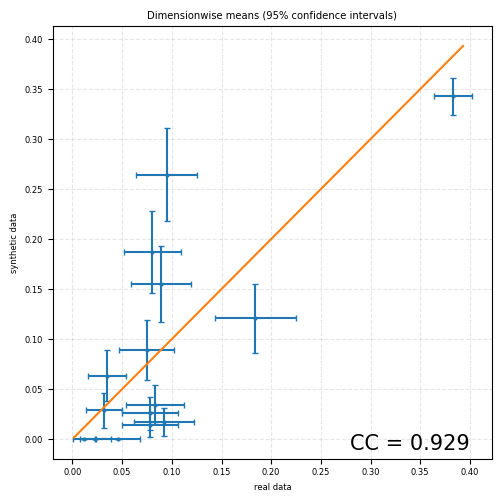

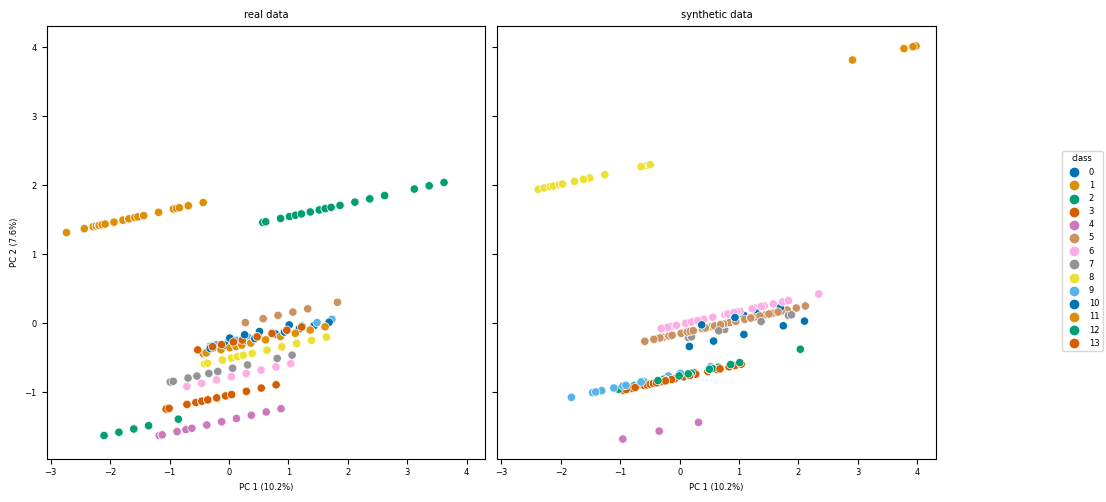

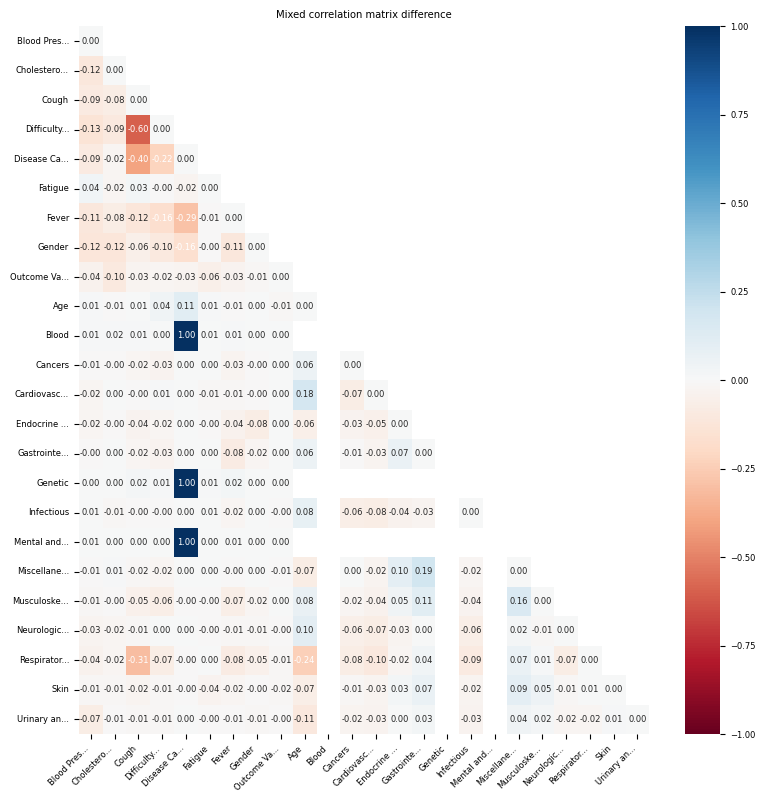

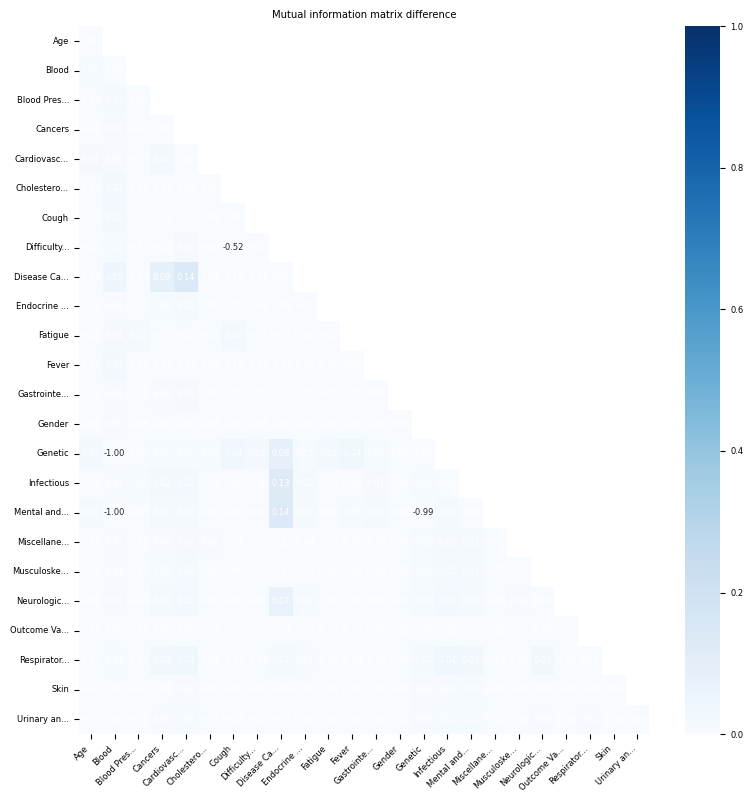

In [182]:
from syntheval import SynthEval

evaluator = SynthEval(original_data_train, nn_distance='euclid',unique_threshold=5)
_ = evaluator.evaluate(generated_data, 'Disease Category', "full_eval")